In [25]:
import cv2
import collections
import datetime
import itertools
import keras.backend
import keras.preprocessing.image
import math
import matplotlib.pyplot
import numpy
import os
import pathlib
import pickle
import re
import skimage.morphology
import skimage.io
import sklearn
import sklearn.model_selection
import sklearn.utils
import tensorflow
import time

from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma
)

In [26]:
def create_if_not_exists_dir(dir):
    if not os.path.isdir(dir):
        os.makedirs(dir)

dir_base = "/home/xandao/herbario/code/piperaceae-segmentation"
current_datetime = datetime.datetime.now().strftime('%d-%m-%Y-%H-%M-%S')
path_model = os.path.join(dir_base, "model")
path_result = os.path.join(dir_base, "result")
path_out = os.path.join(path_result, current_datetime)
path_images = os.path.join(dir_base, "images")
path_mask = os.path.join(dir_base, "mask")

for path in [path_model, path_result, path_out, path_images, path_mask]:
    create_if_not_exists_dir(path)

In [27]:
cross_validation = 10
test_size = 0.15
val_size = 0.05
learning_rate = 0.05
batch_size = 4
epochs = 200

In [28]:
image_size = 400

In [29]:
mean_time_train = 0
sum_iou_train = 0
sum_dice_train = 0
sum_iou_val = 0
sum_dice_val = 0
sum_iou_test = 0
sum_dice_test = 0

In [30]:
class AugmentationSequence(tensorflow.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(numpy.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        aug_x = numpy.zeros(batch_x.shape)
        aug_y = numpy.zeros(batch_y.shape)

        for idx in range(batch_x.shape[0]):
            aug = self.augment(image=batch_x[idx, :, :, :], mask=batch_y[idx, :, :, :])
            aug_x[idx, :, :, :] = aug["image"]
            aug_y[idx, :, :, :] = aug["mask"]

        return aug_x, aug_y

In [31]:
def resize_image(image, image_size):
    return cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_CUBIC)

def get_all_images(dir):
    return [{"filename": file.name, "file": cv2.imread(str(file.resolve()), cv2.IMREAD_GRAYSCALE)}
            for file in pathlib.Path(dir).rglob("*")]

def only_resize(list_images, output_dir, image_size):
    create_if_not_exists_dir(output_dir)
    for image in list_images:
        cv2.imwrite(os.path.join(output_dir, image["filename"]), resize_image(image["file"], image_size))

def resize_all():
    for data in [{"path": "new/images", "type": "images"}, {"path": "new/mask", "type": "mask"}]:
            only_resize(get_all_images(data["path"]), data["type"], 400)

In [32]:
def load_mask(filename):
    return numpy.float32(skimage.io.imread(filename) / 255)

def load_all_masks(path):
    return [load_mask(filename) for filename in sorted(pathlib.Path(path).rglob("*"))]

def load_image(filename):
    return skimage.img_as_float32(skimage.io.imread(filename))

def load_all_images(path):
    return [load_image(filename) for filename in sorted(pathlib.Path(path).rglob("*"))]

def width_height_are_equal_image_size(image, image_size):
    return image.shape[0] == image_size and image.shape[1] == image_size

def validate_data(path, image_size):
    return all(not width_height_are_equal_image_size(skimage.io.imread(filename), image_size) for filename in sorted(pathlib.Path(path).rglob("*")))

if validate_data(path_mask, image_size) and validate_data(path_images, image_size):
    raise SystemExit("err in input file")

def get_genus(filename):
    list_genus = ["manekia", "ottonia", "peperomia", "piper", "pothomorphe"]
    return next((g for g in list_genus if g in filename), ValueError("a"))

def get_path_mask(filename):
    filename = re.sub(r".[a-z]*$", "", filename)
    list_mask = list([str(file.resolve()) for file in pathlib.Path(path_mask).rglob("*")])
    return next((m for m in list_mask if filename in m), ValueError("a"))

def format_data(X, Y):
    return X.reshape(X.shape[0], image_size, image_size, 1), Y.reshape(Y.shape[0], image_size, image_size, 1)

list_images = list([{"path_image": str(file.resolve()), "path_mask": get_path_mask(file.name), "label": get_genus(str(file.name))} for file in pathlib.Path(path_images).rglob("*")])
indices = sklearn.model_selection.StratifiedShuffleSplit(n_splits=cross_validation, test_size=test_size, random_state=1234)

X = numpy.array([{"path_image": file["path_image"], "path_mask": file["path_mask"]} for file in list_images])
Y = numpy.array([file["label"] for file in list_images])

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (375,), Y.shape: (375,)


# GPU

In [33]:
def set_avx_avx2():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # INFO messages are not printed

def set_gpu():
    gpus = tensorflow.config.experimental.list_physical_devices("GPU")
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                print(f"GPU: {gpu.name}")
                tensorflow.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

set_avx_avx2()
set_gpu()

GPU: /physical_device:GPU:0


# U-net

In [34]:
def unet_model(keras=None, img_size=None):

    input_img = tensorflow.keras.layers.Input((img_size, img_size, 1), name = "img")

    # Contract #1
    c1 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(input_img)
    c1 = tensorflow.keras.layers.BatchNormalization()(c1)
    c1 = tensorflow.keras.layers.Activation("relu")(c1)
    c1 = tensorflow.keras.layers.Dropout(0.1)(c1)
    c1 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c1)
    c1 = tensorflow.keras.layers.BatchNormalization()(c1)
    c1 = tensorflow.keras.layers.Activation("relu")(c1)
    p1 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c1)

    # Contract #2
    c2 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p1)
    c2 = tensorflow.keras.layers.BatchNormalization()(c2)
    c2 = tensorflow.keras.layers.Activation("relu")(c2)
    c2 = tensorflow.keras.layers.Dropout(0.2)(c2)
    c2 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c2)
    c2 = tensorflow.keras.layers.BatchNormalization()(c2)
    c2 = tensorflow.keras.layers.Activation("relu")(c2)
    p2 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c2)

    # Contract #3
    c3 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p2)
    c3 = tensorflow.keras.layers.BatchNormalization()(c3)
    c3 = tensorflow.keras.layers.Activation("relu")(c3)
    c3 = tensorflow.keras.layers.Dropout(0.3)(c3)
    c3 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c3)
    c3 = tensorflow.keras.layers.BatchNormalization()(c3)
    c3 = tensorflow.keras.layers.Activation("relu")(c3)
    p3 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c3)

    # Contract #4
    c4 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p3)
    c4 = tensorflow.keras.layers.BatchNormalization()(c4)
    c4 = tensorflow.keras.layers.Activation("relu")(c4)
    c4 = tensorflow.keras.layers.Dropout(0.4)(c4)
    c4 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c4)
    c4 = tensorflow.keras.layers.BatchNormalization()(c4)
    c4 = tensorflow.keras.layers.Activation("relu")(c4)
    p4 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c4)

    # Middle
    c5 = tensorflow.keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p4)
    c5 = tensorflow.keras.layers.BatchNormalization()(c5)
    c5 = tensorflow.keras.layers.Activation("relu")(c5)
    c5 = tensorflow.keras.layers.Dropout(0.5)(c5)
    c5 = tensorflow.keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c5)
    c5 = tensorflow.keras.layers.BatchNormalization()(c5)
    c5 = tensorflow.keras.layers.Activation("relu")(c5)

    # Expand (upscale) #1
    u6 = tensorflow.keras.layers.Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = "same")(c5)
    u6 = tensorflow.keras.layers.concatenate([u6, c4])
    c6 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u6)
    c6 = tensorflow.keras.layers.BatchNormalization()(c6)
    c6 = tensorflow.keras.layers.Activation("relu")(c6)
    c6 = tensorflow.keras.layers.Dropout(0.5)(c6)
    c6 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c6)
    c6 = tensorflow.keras.layers.BatchNormalization()(c6)
    c6 = tensorflow.keras.layers.Activation("relu")(c6)

    # Expand (upscale) #2
    u7 = tensorflow.keras.layers.Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = "same")(c6)
    u7 = tensorflow.keras.layers.concatenate([u7, c3])
    c7 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u7)
    c7 = tensorflow.keras.layers.BatchNormalization()(c7)
    c7 = tensorflow.keras.layers.Activation("relu")(c7)
    c7 = tensorflow.keras.layers.Dropout(0.5)(c7)
    c7 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c7)
    c7 = tensorflow.keras.layers.BatchNormalization()(c7)
    c7 = tensorflow.keras.layers.Activation("relu")(c7)

    # Expand (upscale) #3
    u8 = tensorflow.keras.layers.Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = "same")(c7)
    u8 = tensorflow.keras.layers.concatenate([u8, c2])
    c8 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u8)
    c8 = tensorflow.keras.layers.BatchNormalization()(c8)
    c8 = tensorflow.keras.layers.Activation("relu")(c8)
    c8 = tensorflow.keras.layers.Dropout(0.5)(c8)
    c8 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c8)
    c8 = tensorflow.keras.layers.BatchNormalization()(c8)
    c8 = tensorflow.keras.layers.Activation("relu")(c8)

    # Expand (upscale) #4
    u9 = tensorflow.keras.layers.Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = "same")(c8)
    u9 = tensorflow.keras.layers.concatenate([u9, c1])
    c9 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u9)
    c9 = tensorflow.keras.layers.BatchNormalization()(c9)
    c9 = tensorflow.keras.layers.Activation("relu")(c9)
    c9 = tensorflow.keras.layers.Dropout(0.5)(c9)
    c9 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c9)
    c9 = tensorflow.keras.layers.BatchNormalization()(c9)
    c9 = tensorflow.keras.layers.Activation("relu")(c9)

    output = tensorflow.keras.layers.Conv2D(1, (1, 1), activation = "sigmoid")(c9)
    model = tensorflow.keras.Model(inputs = [input_img], outputs = [output])
    return model

# Metrics

In [35]:
def jaccard_distance_loss(y_true, y_pred, smooth = 100):
    intersection = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true * y_pred), axis = -1)
    union = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true) + tensorflow.keras.backend.abs(y_pred), axis = -1)
    jac = (intersection + smooth) / (union - intersection + smooth)
    loss = (1 - jac) * smooth
    return loss

def dice_coef(y_true, y_pred, smooth = 1):
    intersection = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true * y_pred), axis = -1)
    union = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true), -1) + tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_pred), -1)
    return (2. * intersection + smooth) / (union + smooth)

In [36]:
def crop_image(img, mask):
    crop_mask = mask > 0
    m, n = mask.shape
    crop_mask0, crop_mask1 = crop_mask.any(0), crop_mask.any(1)
    col_start, col_end = crop_mask0.argmax(), n - crop_mask0[::-1].argmax()
    row_start, row_end = crop_mask1.argmax(), m - crop_mask1[::-1].argmax()
    return img[row_start:row_end, col_start:col_end], mask[row_start:row_end, col_start:col_end]

def process_pred_mask(pred_mask):
    open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
    open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
    return skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))

def save_image_mask_predmask(filename, image, mask, pred_mask, post_pred_mask, image_original_mask, image_pred_mask):
    figure = matplotlib.pyplot.figure(figsize=(15, 10))
    figure.add_subplot(2, 3, 1).set_title("Original image", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(skimage.img_as_ubyte(image), cmap = "gray")
    figure.add_subplot(2, 3, 2).set_title("Original mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(skimage.img_as_ubyte(mask), cmap = "gray")
    figure.add_subplot(2, 3, 3).set_title("Predicted mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(pred_mask, cmap = "gray")
    figure.add_subplot(2, 3, 4).set_title("Preprocessed mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(post_pred_mask, cmap = "gray")
    figure.add_subplot(2, 3, 5).set_title("Image original mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(image_original_mask, cmap = "gray")
    figure.add_subplot(2, 3, 6).set_title("Image pred mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(image_pred_mask, cmap = "gray")
    print(f"{filename} created")
    figure.savefig(filename)


def save_images(X, Y, data_type, model, out_folder):
    for idx in range(0, X.shape[0]):
        test_img = X[idx,:,:,:].reshape((1, image_size, image_size, 1))
        test_mask = Y[idx,:,:,:].reshape((1, image_size, image_size, 1))
        pred_mask = model.predict(test_img)[0,:,:,0]
        image_pred_mask = pred_mask
        pred_mask = numpy.uint8(pred_mask > 0.5)

        post_pred_mask = process_pred_mask(pred_mask)
        image_out_folder = os.path.join(out_folder, data_type, f"{idx}")

        # crop_img, crop_mask = crop_image(test_img[0,:,:,0], post_pred_mask) # keep
        image_mask_unet = test_img[0,:,:,0] * pred_mask
        mask_original = numpy.uint8(test_mask[0,:,:,0] > 0.5)
        image_mask_original = test_img[0,:,:,0] * mask_original
        image_mask_unet[image_mask_unet == 0] = 1
        image_mask_original[image_mask_original == 0] = 1

        create_if_not_exists_dir(image_out_folder)

        print(f"{os.path.join(image_out_folder, f'{idx}-original.png')} created")
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-original.png"), skimage.img_as_ubyte(test_img[0,:,:,0]))
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-mask-original.png"), skimage.img_as_ubyte(test_mask[0,:,:,0]))
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-mask-unet.png"), skimage.img_as_ubyte(image_pred_mask))
        # skimage.io.imsave(os.path.join(image_out_folder, f"{i}-post-pred-mask.png"), post_pred_mask * 255)
        # skimage.io.imsave(os.path.join(image_out_folder, f"{i}-crop-img.png"), skimage.img_as_ubyte(crop_img))
        # skimage.io.imsave(os.path.join(image_out_folder, f"{i}-crop-mask.png"), crop_mask * 255)
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-image-mask-unet.png"), skimage.img_as_ubyte(image_mask_unet))
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-image-mask-original.png"), skimage.img_as_ubyte(image_mask_original))

        save_image_mask_predmask(os.path.join(image_out_folder, f"{idx}.png"), test_img[0,:,:,0], test_mask[0,:,:,0], pred_mask, post_pred_mask, image_mask_original, image_mask_unet)


In [37]:
images = load_all_images(path_images)

def set_idx(X_test):
    images_test_ids = []
    for idx in range(X_test.shape[0]):
        test_image = X_test[idx, :, :, 0]
        if any(numpy.array_equal(test_image, x) for x in images):
            images_test_ids.append(idx)

In [38]:
def cfg_model(X_train, Y_train, index_cv):
    steps_per_epoch = math.ceil(X_train.shape[0] / batch_size)
    augment = Compose([
        HorizontalFlip(),
        ShiftScaleRotate(rotate_limit=45, border_mode=cv2.BORDER_CONSTANT),
        ElasticTransform(border_mode=cv2.BORDER_CONSTANT),
        RandomBrightness(),
        RandomContrast(),
        RandomGamma()
    ])
    train_generator = AugmentationSequence(X_train, Y_train, batch_size, augment)
    unet_filename = os.path.join(path_model,
                                 f"batch{batch_size}+lr{str(learning_rate).replace('.', '_')}+epoch{epochs}+steps{steps_per_epoch}+cv{index_cv}+unet.h5")
    reduce_learning_rate = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3,
                                                                        verbose=1)
    checkpointer = tensorflow.keras.callbacks.ModelCheckpoint(unet_filename, verbose=1, save_best_only=True)
    strategy = tensorflow.distribute.MirroredStrategy()
    return checkpointer, reduce_learning_rate, steps_per_epoch, strategy, train_generator, unet_filename

In [39]:
def calculate_iou_dice(X_test, X_train, X_val, Y_test, Y_train, Y_val, model):
    iou_train, dice_train = model.evaluate(X_train, Y_train, verbose=False)
    iou_val, dice_val = model.evaluate(X_val, Y_val, verbose=False)
    iou_test, dice_test = model.evaluate(X_test, Y_test, verbose=False)
    return dice_test, dice_train, dice_val, iou_test, iou_train, iou_val

In [40]:
def create_figure_with_three_columns(X_test, Y_test, model, index_cv, path):
    fig = matplotlib.pyplot.figure(constrained_layout=True, figsize=(60, 20))
    fig.suptitle(f"Result {datetime.datetime.now().strftime('%d/%m/%Y %H:%M:%S')}", fontsize=36, color="r")
    subfigs = fig.subfigures(nrows=3, ncols=1)
    titles = ["Original", "Mask original", "Mask u-net"]
    for i, subfig in enumerate(subfigs):
        subfig.suptitle(titles[i], fontsize=28, color="r")
        axs = subfig.subplots(nrows=1, ncols=8)
        for j, ax in enumerate(axs):
            if i == 0:
                test_img = X_test[j, :, :, :].reshape((1, image_size, image_size, 1))
                ax.imshow(skimage.img_as_ubyte(test_img[0, :, :, 0]), cmap="gray")
            elif i == 1:
                test_mask = Y_test[j, :, :, :].reshape((1, image_size, image_size, 1))
                ax.imshow(skimage.img_as_ubyte(test_mask[0, :, :, 0]), cmap="gray")
            elif i == 2:
                test_img = X_test[j, :, :, :].reshape((1, image_size, image_size, 1))
                pred_mask = model.predict(test_img)[0, :, :, 0]
                ax.imshow(pred_mask, cmap="gray")
    print(f"{os.path.join(path, f'cv-{index_cv}-compartive.png')} created")
    fig.savefig(os.path.join(path, f"cv-{index_cv}-compartive.png"))

In [41]:
def create_outfile_cv(X_test, X_train, X_val, dice_test, dice_train, dice_val, index_cv, iou_test, iou_train, iou_val, path, steps_per_epoch, unet_filename, elapsed_time):
    try:
        print(f"{os.path.join(path, f'cv-{index_cv}-result.txt')} created")
        with open(os.path.join(path, f"cv-{index_cv}-result.txt"), "w") as file:
            file.write(f"unet filename={unet_filename}\n")
            file.write(f"index cv={index_cv}\n")
            file.write(f"elapsed time={elapsed_time}\n")
            file.write(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}\n")
            file.write(f"learning_rate={learning_rate}, batch_size={batch_size}\n")
            file.write(f"epochs={epochs}, steps={steps_per_epoch}\n")
            file.write(f"============================================\n")
            file.write(f"Jaccard distance (IoU) train: {iou_train}\n")
            file.write(f"Dice coeffient train: {dice_train}\n")
            file.write(f"Jaccard distance (IoU) validation: {iou_val}\n")
            file.write(f"Dice coeffient validation: {dice_val}\n")
            file.write(f"Jaccard distance (IoU) test: {iou_test}\n")
            file.write(f"Dice coeffient test: {dice_test}\n")
            file.close()
    except:
        raise SystemError(f"fail in create outfile {os.path.join(path, f'cv-{str(index_cv)}.txt')}")

def calculate_mean_metrics(path):
    try:
        print(f"{os.path.join(path, '-mean')}.txt created")
        with open(f"{os.path.join(path, '-mean')}.txt", "w") as outfile:
            outfile.write(f"Mean Jaccard distance (IoU) train: {sum_iou_train / cross_validation}\n")
            outfile.write(f"Mean Dice coeffient train: {sum_dice_train / cross_validation}\n")
            outfile.write(f"Mean Jaccard distance (IoU) validation: {sum_iou_val / cross_validation}\n")
            outfile.write(f"Mean Dice coeffient validation: {sum_dice_val / cross_validation}\n")
            outfile.write(f"Mean Jaccard distance (IoU) test: {sum_iou_test / cross_validation}\n")
            outfile.write(f"Mean Dice coeffient test: {sum_dice_test / cross_validation}\n")
            outfile.close()
    except:
        raise SystemError(f"fail in create outfile {os.path.join(path, 'mean')}.txt")

def images_used(X, path, type):
     try:
        print(f"{os.path.join(path, f'{type}images-used.csv')} created")
        with open(os.path.join(path, f"{type}images-used.csv"), "w") as file:
            file.write("path_image;path_mask\n")
            for x in X:
                file.write(f"\"{list(x.values())[0]}\";\"{list(x.values())[1]}\"\n")
            file.close()
     except:
         raise SystemExit(f"error in create file")

In [42]:
def save_all_images(X_test, X_train, X_val, Y_test, Y_train, Y_val, model, out_folder_index_cv):
    save_images(X_train, Y_train, "train", model, out_folder_index_cv)
    save_images(X_test, Y_test, "test", model, out_folder_index_cv)
    save_images(X_val, Y_val, "val", model, out_folder_index_cv)

In [43]:
def plot_loss_graph(model, index_cv, path):
    fig, ax = matplotlib.pyplot.subplots(1, figsize=(10, 10))
    ax.plot(model.history["loss"], label="Train", linewidth=2, marker="o")
    ax.plot(model.history["val_loss"], label="Validation", linewidth=2, marker="o")
    ax.plot(model.history["lr"], label="Learning rate", linewidth=2, marker="o")
    fig.suptitle("Train, Validation and Learning Rate", color="r", fontsize=20, fontweight="bold", verticalalignment="center")
    ax.set_ylabel("Loss", color="r", fontsize=16)
    ax.set_xlabel("Epoch", color="r", fontsize=16)
    ax.legend()
    print(f"{os.path.join(path, f'cv-{index_cv}-lossgraph.png')} created")
    fig.savefig(os.path.join(path, f"cv-{index_cv}-lossgraph.png"))

In [44]:
def save_fit_history(fit, index_cv, path):
    try:
        with open(os.path.join(path, f"cv{index_cv}-fit.pckl"), "wb") as file:
            pickle.dump(fit.history, file)
            file.close()
    except:
        raise SystemExit(f"error in create cv{index_cv}-fit.pckl")

In [45]:
import sys
def train_test(index_cv, X_train, Y_train, X_val, Y_val, X_test, Y_test, sum_iou_train, sum_dice_train, sum_iou_val, sum_dice_val, sum_iou_test, sum_dice_test, path):
    print(f"cv -> {index_cv}")
    print(f"X_train.shape: {X_train.shape}, Y_train.shape: {Y_train.shape}")
    print(f"X_val.shape: {X_val.shape}, Y_val.shape: {Y_val.shape}")
    print(f"X_test.shape: {X_test.shape}, Y_test.shape: {Y_test.shape}")

    set_idx(X_test)
    checkpointer, reduce_learning_rate, steps_per_epoch, strategy, train_generator, unet_filename = cfg_model(X_train, Y_train, index_cv)

    elapsed_time = None
    model = None
    fit = None

    if os.path.exists(unet_filename):
        model = tensorflow.keras.models.load_model(unet_filename, custom_objects = {"jaccard_distance_loss": jaccard_distance_loss,"dice_coef": dice_coef})
    else:
        with strategy.scope():
            model = unet_model()
            adam_opt = tensorflow.keras.optimizers.Adam(learning_rate = learning_rate)
            model.compile(optimizer = adam_opt, loss = jaccard_distance_loss, metrics = [dice_coef])

        start_time = time.time()
        fit = model.fit(train_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = epochs,
            validation_data = (X_val, Y_val),
            callbacks = [checkpointer, reduce_learning_rate]
        )
        elapsed_time = time.time() - start_time
        print(f"time elapsed {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")

        save_fit_history(fit, index_cv, path)
        plot_loss_graph(fit, index_cv, path)


    dice_test, dice_train, dice_val, iou_test, iou_train, iou_val = calculate_iou_dice(X_test, X_train, X_val, Y_test,Y_train, Y_val, model)

    sum_iou_train += iou_train
    sum_dice_train += dice_train
    sum_iou_val += iou_val
    sum_dice_val += dice_val
    sum_iou_test += iou_test
    sum_dice_test += dice_test

    create_figure_with_three_columns(X_test, Y_test, model, index_cv, path)

    create_outfile_cv(X_test, X_train, X_val, dice_test, dice_train, dice_val, index_cv, iou_test, iou_train, iou_val, path, steps_per_epoch, unet_filename, elapsed_time)

    save_all_images(X_test, X_train, X_val, Y_test, Y_train, Y_val, model, path)

In [46]:
def load_data(X, Y, path, type):
    images_used(X, path, type)
    X = numpy.array(list([load_image(x["path_image"]) for x in X]))
    Y = numpy.array(list([load_mask(y["path_mask"]) for y in Y]))
    return X.reshape(X.shape[0], image_size, image_size, 1), Y.reshape(Y.shape[0], image_size, image_size, 1)

def load_all_data(X_train, X_val, X_test, path):
    X_train, Y_train = load_data(X_train, numpy.copy(X_train), path, "train")
    X_val, Y_val = load_data(X_val, numpy.copy(X_val), path, "val")
    X_test, Y_test = load_data(X_test, numpy.copy(X_test), path, "test")
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [47]:
def test_cross_validation():
    for i, (train_index, test_index) in enumerate(indices.split(X, Y)):
        keras.backend.clear_session()

        out_folder_index_cv = os.path.join(path_out, f"cv-{i}")
        create_if_not_exists_dir(out_folder_index_cv)

        X_train, Y_train = X[train_index], X[train_index]
        X_test, Y_test = X[test_index], X[test_index]
        X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=val_size, random_state=1234)
        X_train, Y_train, X_val, Y_val, X_test, Y_test = load_all_data(X_train, X_val, X_test, out_folder_index_cv)

        train_test(i, X_train, Y_train, X_val, Y_val, X_test, Y_test, sum_iou_train, sum_dice_train, sum_iou_val, sum_dice_val, sum_iou_test, sum_dice_test, out_folder_index_cv)

    calculate_mean_metrics(path_out)

def without_cross_validation():
    keras.backend.clear_session()

    index_cv=999
    out_folder_index_cv = os.path.join(path_out, f"cv-{str(index_cv)}")
    create_if_not_exists_dir(out_folder_index_cv)

    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=test_size, random_state=1234)
    X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=val_size, random_state=1234)
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_all_data(X_train, X_val, X_test, out_folder_index_cv)

    train_test(index_cv, X_train, Y_train, X_val, Y_val, X_test, Y_test, sum_iou_train, sum_dice_train, sum_iou_val, sum_dice_val, sum_iou_test, sum_dice_test, out_folder_index_cv)

/home/xandao/herbario/code/piperaceae-segmentation/result/10-07-2022-00-13-33/cv-999/trainimages-used.csv created
/home/xandao/herbario/code/piperaceae-segmentation/result/10-07-2022-00-13-33/cv-999/valimages-used.csv created
/home/xandao/herbario/code/piperaceae-segmentation/result/10-07-2022-00-13-33/cv-999/testimages-used.csv created
cv -> 999
X_train.shape: (302, 400, 400, 1), Y_train.shape: (302, 400, 400, 1)
X_val.shape: (16, 400, 400, 1), Y_val.shape: (16, 400, 400, 1)
X_test.shape: (57, 400, 400, 1), Y_test.shape: (57, 400, 400, 1)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 t

2022-07-10 00:13:39.727653: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_31005"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:5405"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

19/19 [==============================] - ETA: 0s - loss: 0.2432 - dice_coef: 0.8615

2022-07-10 00:14:09.450721: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_38543"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:5430"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO


Epoch 1: val_loss improved from inf to 0.21652, saving model to /home/xandao/herbario/code/piperaceae-segmentation/model/batch16+lr0_05+epoch4+steps19+cv999+unet.h5
19/19 [==============================] - 31s 1s/step - loss: 0.2432 - dice_coef: 0.8615 - val_loss: 0.2165 - val_dice_coef: 0.8887 - lr: 0.0500
Epoch 2/4
19/19 [==============================] - ETA: 0s - loss: 0.0962 - dice_coef: 0.9504
Epoch 2: val_loss did not improve from 0.21652
19/19 [==============================] - 26s 1s/step - loss: 0.0962 - dice_coef: 0.9504 - val_loss: 0.2165 - val_dice_coef: 0.8887 - lr: 0.0500
Epoch 3/4
19/19 [==============================] - ETA: 0s - loss: 0.0709 - dice_coef: 0.9624
Epoch 3: val_loss improved from 0.21652 to 0.19687, saving model to /home/xandao/herbario/code/piperaceae-segmentation/model/batch16+lr0_05+epoch4+steps19+cv999+unet.h5
19/19 [==============================] - 27s 1s/step - loss: 0.0709 - dice_coef: 0.9624 - val_loss: 0.1969 - val_dice_coef: 0.8983 - lr: 0.050

ValueError: 'middle' is not a valid value for align; supported values are 'top', 'bottom', 'center', 'baseline', 'center_baseline'

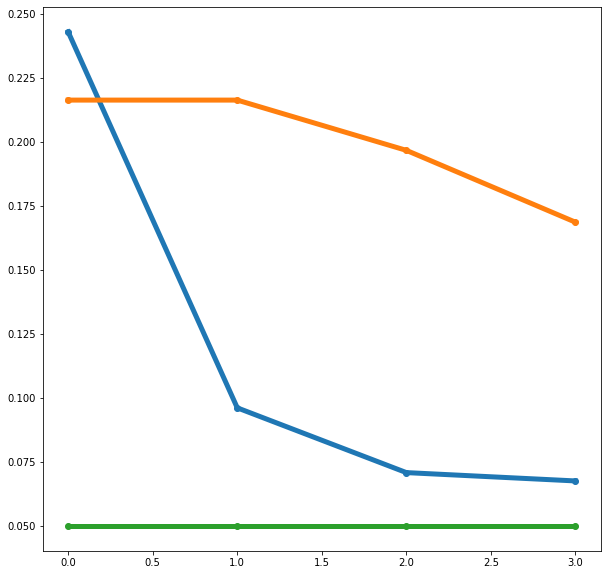

In [48]:
if cross_validation > 1:
    test_cross_validation()
else:
    without_cross_validation()